In [ ]:
from astropy.io import fits
import numpy as np
import numpy as np
import pandas as pd
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from tqdm import tqdm
import warnings
import pickle
from extreme_deconvolution import extreme_deconvolution
from scipy.linalg import det 
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014

warnings.filterwarnings("ignore", category=FutureWarning)

# File path
filtered_corrected_galpy_data = 'data/Allsky_Gaia_8910601_rv_extinction_corrected_filtered_galpy.fits'

# Clustering by Binning (4d Historgam)

In [390]:
with fits.open(filtered_corrected_galpy_data, memmap=True) as hdul:
    stream_data = hdul[1].data
    stream_df = Table(stream_data).to_pandas()
    l = stream_df['l']
    b = stream_df['b']
    energy = stream_df['energy']
    Lz = stream_df['Lz']
    R_gal = stream_df['R_gal']

# Remove stars with R < 1 kpc
stream_df = stream_df[R_gal >2]
l = stream_df['l']
b = stream_df['b']
energy = stream_df['energy']
Lz = stream_df['Lz']
R_gal = stream_df['R_gal']




In [391]:
display(stream_df.describe())

,source_id,l,b,ra,dec,ra_error,dec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,...,r_hi_photogeo,r_lo_photogeo,dered_G,dered_BP,dered_RP,dered_BP_RP,M_G,energy,Lz,R_gal
count,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,...,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06
mean,4.343797e+18,1.837335e+02,-9.459711e-01,2.258956e+02,-1.681869e+01,1.880051e-02,1.738173e-02,1.445456e+01,1.543461e+01,1.350958e+01,...,5.528049e+03,4.435312e+03,1.339232e+01,1.390468e+01,1.260334e+01,1.301343e+00,4.055386e-02,-5.745670e+04,1.251454e+03,6.757426e+00
std,1.693791e+18,1.306440e+02,1.193433e+01,7.888563e+01,3.791089e+01,8.018817e-03,6.414487e-03,7.619720e-01,9.435168e-01,7.364850e-01,...,2.249807e+03,1.462621e+03,8.312038e-01,9.148638e-01,8.927022e-01,2.701550e-01,9.213969e-01,2.367107e+04,7.420915e+02,3.007537e+00
min,9.009553e+13,7.374925e-05,-8.969809e+01,6.117030e-04,-8.996995e+01,3.945457e-03,4.656644e-03,1.000015e+01,1.053315e+01,8.611038e+00,...,1.693511e+03,8.751464e+02,6.599596e+00,6.292698e+00,5.780555e+00,5.000029e-01,-9.204772e+00,-1.292145e+05,-8.711174e+03,2.000001e+00
25%,3.418265e+18,4.697036e+01,-6.982882e+00,1.728346e+02,-4.950756e+01,1.309325e-02,1.294093e-02,1.402488e+01,1.484709e+01,1.312463e+01,...,3.981171e+03,3.419286e+03,1.292607e+01,1.342088e+01,1.210133e+01,1.138027e+00,-5.408297e-01,-7.369442e+04,7.042663e+02,4.492904e+00
50%,4.314505e+18,2.038350e+02,-2.636230e+00,2.564047e+02,-2.282593e+01,1.721662e-02,1.623385e-02,1.458911e+01,1.544150e+01,1.368153e+01,...,4.976705e+03,4.108673e+03,1.351829e+01,1.406656e+01,1.274053e+01,1.272947e+00,2.601786e-01,-5.560048e+04,1.178342e+03,6.113160e+00
75%,5.858346e+18,3.132719e+02,5.606293e+00,2.828485e+02,1.130025e+01,2.294823e-02,2.033336e-02,1.499948e+01,1.601863e+01,1.406900e+01,...,6.370588e+03,5.017613e+03,1.401174e+01,1.457885e+01,1.326890e+01,1.467030e+00,6.749306e-01,-3.802143e+04,1.788578e+03,8.885597e+00
max,6.917527e+18,3.600000e+02,8.993158e+01,3.599999e+02,8.990038e+01,2.963450e-01,3.878340e-01,1.806356e+01,2.036324e+01,1.755235e+01,...,1.027068e+05,4.489459e+04,1.786672e+01,1.803785e+01,1.741093e+01,1.999999e+00,3.814045e+00,5.251557e+05,2.166994e+04,5.318119e+01


In [392]:
# Define bin sizes of scanning
l_b_bin_width = 2  # Galactic Longitude/Latitude bin width (±16
# Energy_width = 1000  # Energy bin width
Lz_width = 350      # Lz bin width
R_gal_width = 2  # R_gal bin width
threshold = 0.2  # Threshold for filtering PM bins

# Identify bin centers -- Proper non-overlapping spacing
l_centers = np.arange(min(l) + l_b_bin_width / 2, max(l), l_b_bin_width)
b_centers = np.arange(min(b) + l_b_bin_width / 2, max(b), l_b_bin_width)
Lz_centers = np.arange(min(Lz) + Lz_width / 2, max(Lz), Lz_width)
R_gal_centers = np.arange(min(R_gal) + R_gal_width / 2, max(R_gal), R_gal_width)

# Compute edges correctly from centers (proper non-overlapping bins)
l_edges = np.arange(min(l), max(l) + l_b_bin_width, l_b_bin_width)
b_edges = np.arange(min(b), max(b) + l_b_bin_width, l_b_bin_width)
Lz_edges = np.arange(min(Lz), max(Lz) + Lz_width, Lz_width)
R_gal_edges = np.arange(min(R_gal), max(R_gal) + R_gal_width, R_gal_width)

# 4D Histogram: Galactic Longitude, Latitude, PM_RA, PM_DEC
hist_4d, edges_4d = np.histogramdd((l, b, Lz, R_gal), bins=[l_edges, b_edges, Lz_edges, R_gal_edges])

# 2D Histogram: Total sum of stars in each (l, b) bin from collapsed 4D
hist_2d = np.sum(hist_4d, axis=(2,3))

# Filter PM bins where sum is ≥ threshold% of the corresponding 2D bin
mask = (hist_4d >= threshold * hist_2d[:,:,None,None]) & (hist_4d > 20)
filtered_4d_hist = np.where(mask, hist_4d, 0)


# Total number of bins in the 4D histogram and number of non-empty bins
total_bins = filtered_4d_hist.size
nonzero_bins = np.count_nonzero(filtered_4d_hist)

# Collapse PM_RA and PM_DEC to get a 2D histogram in (l, b)
filtered_2d_hist = np.sum(filtered_4d_hist, axis=(2,3))
# Total number of (l, b) bins and non-zero bins
total_bins_2d = filtered_2d_hist.size
nonzero_bins_2d = np.count_nonzero(filtered_2d_hist)

# Print results
print(f"Total number of 4D bins: {total_bins}")
print(f"Number of nonzero 4D bins: {nonzero_bins}")
print(f"Total number of (l, b) 2D bins: {total_bins_2d}")
print(f"Number of nonzero (l, b) 2D bins: {nonzero_bins_2d}")


Total number of 4D bins: 36644400
Number of nonzero 4D bins: 8596
Total number of (l, b) 2D bins: 16200
Number of nonzero (l, b) 2D bins: 5093


In [393]:
# Cluster stars in adjacent 4D Bin
nonzero_mask = filtered_4d_hist > 0

# Define a strict 4D connectivity structure (ensuring adjacency in all 4D dimensions)
structure = generate_binary_structure(rank=4, connectivity=1)

# Apply labeling to identify distinct clusters
labeled_array, num_features = label(nonzero_mask, structure=structure)

# Store cluster Galactic Longitude, Latitude, and Proper Motion ranges
cluster_ranges = []

# Loop through each cluster ID with tqdm for progress tracking
for i in tqdm(range(1, num_features + 1), desc="Processing Clusters"):  # Cluster labels start from 1
    indices = np.argwhere(labeled_array == i)  # Get all (L, B, PM_RA, PM_DEC) indices for cluster

    # Extract corresponding Galactic Longitude and Latitude bin edges
    l_min = l_edges[min(indices[:, 0])]  # Min L bin edge
    l_max = l_edges[max(indices[:, 0]) + 1]  # Max L bin edge (next bin's start)
    b_min = b_edges[min(indices[:, 1])]  # Min B bin edge
    b_max = b_edges[max(indices[:, 1]) + 1]  # Max B bin edge (next bin's start)


    # Extract corresponding Lz bin edges
    Lz_min = Lz_edges[min(indices[:, 2])]  # Min Lz bin edge
    Lz_max = Lz_edges[max(indices[:, 2]) + 1]  # Max Lz bin edge (next bin's start)

    # Extract corresponding R_gal bin edges
    R_gal_min = R_gal_edges[min(indices[:, 3])]  # Min R_gal bin edge
    R_gal_max = R_gal_edges[max(indices[:, 3]) + 1]  # Max R_gal bin edge (next bin's start)

    # Store results
    cluster_ranges.append([i, l_min, l_max, b_min, b_max, Lz_min, Lz_max, R_gal_min, R_gal_max])

Processing Clusters: 100%|██████████| 132/132 [00:11<00:00, 11.74it/s]


In [394]:
# Identify clusters that are fully contained within another cluster
clusters_to_remove = set()

for i, cluster_outer in enumerate(cluster_ranges):
    cluster_id_outer, l_min_outer, l_max_outer, b_min_outer, b_max_outer, Lz_min_outer, Lz_max_outer, R_gal_min_outer, R_gal_max_outer = cluster_outer

    for j, cluster_inner in enumerate(cluster_ranges):
        if i == j:  # Skip self-comparison
            continue

        cluster_id_inner, l_min_inner, l_max_inner, b_min_inner, b_max_inner, Lz_min_inner, Lz_max_inner, R_gal_min_inner, R_gal_max_inner = cluster_inner

        # Check if inner cluster is fully contained within outer cluster
        if (l_min_outer <= l_min_inner <= l_max_inner <= l_max_outer) and \
           (b_min_outer <= b_min_inner <= b_max_inner <= b_max_outer) and \
           (Lz_min_outer <= Lz_min_inner <= Lz_max_inner <= Lz_max_outer) and \
           (R_gal_min_outer <= R_gal_min_inner <= R_gal_max_inner <= R_gal_max_outer):
            clusters_to_remove.add(j)  # Mark the inner cluster for removal

# Remove fully contained clusters
cluster_ranges = [cluster for i, cluster in enumerate(cluster_ranges) if i not in clusters_to_remove]

# Print the number of removed clusters
print(f"Removed {len(clusters_to_remove)} fully contained clusters.")

Removed 100 fully contained clusters.


In [395]:
# # Function to transform Galactic Longitude (l) to common sky coordinates
# def transform_l(l_values):
#     # transformed = (90 - l_values)  # Convert l to 90 - l
#     transformed = - l_values  # Convert l to 90 - l
#     transformed = (transformed + 180) % 360 - 180  # Wrap to [-180, 180] range
#     return transformed

# # Identify occupied L-B bins from filtered 2D histogram
# occupied_l_b = np.argwhere(filtered_2d_hist > 0)

# # Convert indices to Galactic Longitude (L) and Latitude (B) centers
# l_occupied = transform_l(l_centers[occupied_l_b[:, 0]])  # Apply transformation
# b_occupied = b_centers[occupied_l_b[:, 1]]  # Latitude remains the same



# # Create a scatter plot of occupied bins
# plt.figure(figsize=(12, 8))
# plt.scatter(l_occupied, b_occupied, marker='s', s=50, alpha=0.3, label="Occupied Bins", color='gray')


# # Add boxes for clusters
# for cluster in cluster_ranges:
#     cluster_id, l_min, l_max, b_min, b_max = cluster[:5]  # Extract relevant cluster info

#     # Transform l_min and l_max
#     l_min_transformed = transform_l(l_min)
#     l_max_transformed = transform_l(l_max)

#     # Ensure correct ordering for box plotting (min should be left, max should be right)
#     if l_min_transformed > l_max_transformed:
#         l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed
    

#     if abs(l_min_transformed - l_max_transformed) > 100:
#         continue



#     # Draw the cluster box with transformed l values
#     plt.plot(
#         [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
#         [b_min, b_min, b_max, b_max, b_min],
#         '-', color='red', linewidth=1
#     )

# # Labels and formatting
# plt.xlabel("Transformed Galactic Longitude (90 - l) [degrees]", fontsize=12)
# plt.ylabel("Galactic Latitude (b) [degrees]", fontsize=12)
# plt.title("Identified and Unidentified Clusters in Common Sky Coordinates", fontsize=14)


# # Custom legend
# plt.plot([], [], 'b--', label="Unidentified Clusters (N/A)")
# plt.plot([], [], 'r-', label="Identified Clusters (PMGC)")
# plt.legend(fontsize=10, loc="lower left")

# plt.grid(True, linestyle=":", alpha=0.7)  # Light dotted grid for clarity
# plt.show()

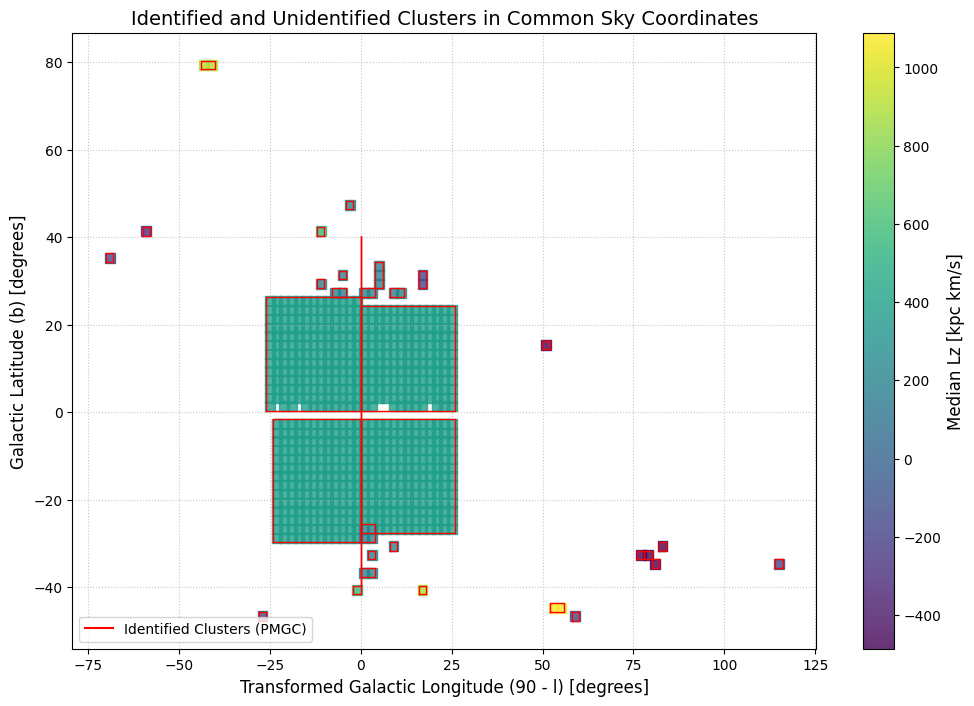

In [396]:

# Function to transform Galactic Longitude (l) to common sky coordinates
def transform_l(l_values):
    transformed = -l_values  # Convert l to -l
    transformed = (transformed + 180) % 360 - 180  # Wrap to [-180, 180] range
    return transformed

# Identify occupied L-B bins from filtered 2D histogram
occupied_l_b = np.argwhere(filtered_2d_hist > 0)

# Convert indices to Galactic Longitude (L) and Latitude (B) centers
l_occupied = transform_l(l_centers[occupied_l_b[:, 0]])  # Apply transformation
b_occupied = b_centers[occupied_l_b[:, 1]]  # Latitude remains the same

# Assign each occupied bin to a cluster's median Lz
Lz_med_values = np.full(len(l_occupied), np.nan)  # Initialize array to store median Lz per occupied bin

for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max, Lz_min, Lz_max, R_gal_min, R_gal_max= cluster[:9]  # Extract relevant cluster info

    # Transform l_min and l_max
    l_min_transformed = transform_l(l_min)
    l_max_transformed = transform_l(l_max)
    Lz_med = (Lz_min + Lz_max) / 2  # Compute median Lz
    R_gal_med = (R_gal_min + R_gal_max) / 2  # Compute median R_gal

    # Ensure correct ordering for box plotting (min should be left, max should be right)
    if l_min_transformed > l_max_transformed:
        l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

    # Skip extreme wrap-around cases
    if abs(l_min_transformed - l_max_transformed) > 100:
        continue

    # Assign Lz_med to points inside the cluster box
    inside_cluster = (l_occupied >= l_min_transformed) & (l_occupied <= l_max_transformed) & \
                     (b_occupied >= b_min) & (b_occupied <= b_max)
    
    Lz_med_values[inside_cluster] = Lz_med  # Assign median Lz to corresponding points

# Plot scatter plot with color-coded Lz_med
plt.figure(figsize=(12, 8))

# Scatter plot where color represents median Lz of the cluster the point is inside
sc = plt.scatter(l_occupied, b_occupied, marker='s', s=50, alpha=0.8, c=Lz_med_values, cmap='viridis')

# Labels and formatting
plt.xlabel("Transformed Galactic Longitude (90 - l) [degrees]", fontsize=12)
plt.ylabel("Galactic Latitude (b) [degrees]", fontsize=12)
plt.title("Identified and Unidentified Clusters in Common Sky Coordinates", fontsize=14)

# Add cluster boxes
for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max, Lz_min, Lz_max = cluster[:7]

    # Transform l_min and l_max
    l_min_transformed = transform_l(l_min)
    l_max_transformed = transform_l(l_max)

    if l_min_transformed > l_max_transformed:
        l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

    if abs(l_min_transformed - l_max_transformed) > 100:
        continue

    # Draw cluster box
    plt.plot(
        [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
        [b_min, b_min, b_max, b_max, b_min],
        '-', color='red', linewidth=1
    )

# Add colorbar for Lz_med
cbar = plt.colorbar(sc)
cbar.set_label("Median Lz [kpc km/s]", fontsize=12)

# Custom legend
plt.plot([], [], 'r-', label="Identified Clusters (PMGC)")
plt.legend(fontsize=10, loc="lower left")

plt.grid(True, linestyle=":", alpha=0.7)  # Light dotted grid for clarity
plt.show()

In [397]:

# # Function to transform Galactic Longitude (l) to common sky coordinates
# def transform_l(l_values):
#     transformed = -l_values  # Convert l to -l
#     transformed = (transformed + 180) % 360 - 180  # Wrap to [-180, 180] range
#     return transformed

# # Identify occupied L-B bins from filtered 2D histogram
# occupied_l_b = np.argwhere(filtered_2d_hist > 0)

# # Convert indices to Galactic Longitude (L) and Latitude (B) centers
# l_occupied = l_centers[occupied_l_b[:, 0]]  # Keep l in original system
# b_occupied = b_centers[occupied_l_b[:, 1]]  # Latitude remains the same

# # Transform l_occupied for plotting
# l_occupied_transformed = transform_l(l_occupied)

# # Assign each occupied bin to a cluster's median R_gal
# R_gal_med_values = np.full(len(l_occupied), np.nan)  # Initialize array

# for cluster in cluster_ranges:
#     cluster_id, l_min, l_max, b_min, b_max, Lz_min, Lz_max, R_gal_min, R_gal_max = cluster[:9]  # Extract relevant cluster info

#     # Transform l_min and l_max
#     l_min_transformed = transform_l(l_min)
#     l_max_transformed = transform_l(l_max)

#     R_gal_med = (R_gal_min + R_gal_max) / 2  # Compute median R_gal

#     # Ensure correct ordering for box plotting
#     if l_min_transformed > l_max_transformed:
#         l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

#     # Skip extreme wrap-around cases
#     if abs(l_min_transformed - l_max_transformed) > 100:
#         continue

#     # Assign R_gal_med to points inside the cluster box
#     inside_cluster = (l_occupied_transformed >= l_min_transformed) & (l_occupied_transformed <= l_max_transformed) & \
#                      (b_occupied >= b_min) & (b_occupied <= b_max)
    
#     R_gal_med_values[inside_cluster] = R_gal_med  # Assign median R_gal to corresponding points

# # Plot scatter plot with color-coded R_gal_med
# plt.figure(figsize=(12, 6))

# # Scatter plot where color represents median R_gal of the cluster the point is inside
# sc = plt.scatter(l_occupied_transformed, b_occupied, marker='s', s=50, alpha=0.8, c=R_gal_med_values, cmap='plasma')

# # Labels and formatting
# plt.xlabel("Transformed Galactic Longitude (90 - l) [degrees]", fontsize=12)
# plt.ylabel("Galactic Latitude (b) [degrees]", fontsize=12)
# plt.title("Identified and Unidentified Clusters in Common Sky Coordinates", fontsize=14)

# # Add cluster boxes
# for cluster in cluster_ranges:
#     cluster_id, l_min, l_max, b_min, b_max, Lz_min, Lz_max, R_gal_min, R_gal_max = cluster[:9]

#     # Transform l_min and l_max
#     l_min_transformed = transform_l(l_min)
#     l_max_transformed = transform_l(l_max)

#     if l_min_transformed > l_max_transformed:
#         l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

#     if abs(l_min_transformed - l_max_transformed) > 100:
#         continue

#     # Draw cluster box
#     plt.plot(
#         [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
#         [b_min, b_min, b_max, b_max, b_min],
#         '-', color='red', linewidth=1
#     )

# # Add colorbar for R_gal_med
# cbar = plt.colorbar(sc)
# cbar.set_label("Median R_gal [kpc]", fontsize=12)

# # Custom legend
# plt.plot([], [], 'r-', label="Identified Clusters (PMGC)")
# plt.legend(fontsize=10, loc="lower left")

# plt.grid(True, linestyle=":", alpha=0.7)  # Light dotted grid for clarity
# plt.show()

In [398]:
# # Function to transform Galactic Longitude (l) to common sky coordinates
# def transform_l(l_values):
#     transformed = -l_values  # Convert l to -l
#     transformed = (transformed + 180) % 360 - 180  # Wrap to [-180, 180] range
#     return transformed

# # Transform the Galactic longitudes of stars in the dataset
# l_transformed = transform_l(l)

# # Initialize array to store median R_gal per star
# R_gal_colors = np.full(len(l_transformed), np.nan)

# # Loop through clusters and assign median R_gal to stars inside each cluster
# for cluster in cluster_ranges:
#     cluster_id, l_min, l_max, b_min, b_max, Lz_min, Lz_max, R_gal_min, R_gal_max = cluster[:9]  # Extract cluster info

#     # Transform cluster longitude for correct matching
#     l_min_transformed = transform_l(l_min)
#     l_max_transformed = transform_l(l_max)
    
#     # Compute median R_gal
#     R_gal_med = (R_gal_min + R_gal_max) / 2  

#     # Ensure correct ordering for longitude range
#     if l_min_transformed > l_max_transformed:
#         l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

#     # Skip extreme wrap-around cases
#     if abs(l_min_transformed - l_max_transformed) > 100:
#         continue

#     # Select stars that fall within the cluster's longitude and latitude range
#     inside_cluster = (l_transformed >= l_min_transformed) & (l_transformed <= l_max_transformed) & \
#                      (b >= b_min) & (b <= b_max) & (Lz >= Lz_min) & (Lz <= Lz_max) & (R_gal >= R_gal_min) & (R_gal <= R_gal_max)
    
#     # Assign median R_gal value of the cluster to matching stars
#     R_gal_colors[inside_cluster] = R_gal_med

# # Plot scatter plot of individual stars colored by cluster median R_gal
# plt.figure(figsize=(12, 6))

# # Scatter plot where each star's color represents the median R_gal of its associated cluster
# sc = plt.scatter(l_transformed, b, marker='o', s=1, alpha=0.7, c=R_gal_colors, cmap='plasma')

# # Labels and formatting
# plt.xlabel("Transformed Galactic Longitude (90 - l) [degrees]", fontsize=12)
# plt.ylabel("Galactic Latitude (b) [degrees]", fontsize=12)
# plt.title("Stars in Clusters Color-Coded by Median R_gal", fontsize=14)

# # Add cluster boxes
# for cluster in cluster_ranges:
#     cluster_id, l_min, l_max, b_min, b_max, Lz_min, Lz_max, R_gal_min, R_gal_max = cluster[:9]

#     # Transform l_min and l_max
#     l_min_transformed = transform_l(l_min)
#     l_max_transformed = transform_l(l_max)

#     if l_min_transformed > l_max_transformed:
#         l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

#     if abs(l_min_transformed - l_max_transformed) > 100:
#         continue

#     # Draw cluster box
#     plt.plot(
#         [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
#         [b_min, b_min, b_max, b_max, b_min],
#         '-', color='red', linewidth=1
#     )

# # Add colorbar for R_gal_med
# cbar = plt.colorbar(sc)
# cbar.set_label("Median R_gal [kpc]", fontsize=12)

# # Custom legend
# plt.plot([], [], 'r-', label="Identified Clusters (PMGC)")
# plt.legend(fontsize=10, loc="lower left")

# plt.grid(True, linestyle=":", alpha=0.7)  # Light dotted grid for clarity
# plt.show()

In [399]:
display(stream_df.describe())

,source_id,l,b,ra,dec,ra_error,dec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,...,r_hi_photogeo,r_lo_photogeo,dered_G,dered_BP,dered_RP,dered_BP_RP,M_G,energy,Lz,R_gal
count,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,...,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06,6.827563e+06
mean,4.343797e+18,1.837335e+02,-9.459711e-01,2.258956e+02,-1.681869e+01,1.880051e-02,1.738173e-02,1.445456e+01,1.543461e+01,1.350958e+01,...,5.528049e+03,4.435312e+03,1.339232e+01,1.390468e+01,1.260334e+01,1.301343e+00,4.055386e-02,-5.745670e+04,1.251454e+03,6.757426e+00
std,1.693791e+18,1.306440e+02,1.193433e+01,7.888563e+01,3.791089e+01,8.018817e-03,6.414487e-03,7.619720e-01,9.435168e-01,7.364850e-01,...,2.249807e+03,1.462621e+03,8.312038e-01,9.148638e-01,8.927022e-01,2.701550e-01,9.213969e-01,2.367107e+04,7.420915e+02,3.007537e+00
min,9.009553e+13,7.374925e-05,-8.969809e+01,6.117030e-04,-8.996995e+01,3.945457e-03,4.656644e-03,1.000015e+01,1.053315e+01,8.611038e+00,...,1.693511e+03,8.751464e+02,6.599596e+00,6.292698e+00,5.780555e+00,5.000029e-01,-9.204772e+00,-1.292145e+05,-8.711174e+03,2.000001e+00
25%,3.418265e+18,4.697036e+01,-6.982882e+00,1.728346e+02,-4.950756e+01,1.309325e-02,1.294093e-02,1.402488e+01,1.484709e+01,1.312463e+01,...,3.981171e+03,3.419286e+03,1.292607e+01,1.342088e+01,1.210133e+01,1.138027e+00,-5.408297e-01,-7.369442e+04,7.042663e+02,4.492904e+00
50%,4.314505e+18,2.038350e+02,-2.636230e+00,2.564047e+02,-2.282593e+01,1.721662e-02,1.623385e-02,1.458911e+01,1.544150e+01,1.368153e+01,...,4.976705e+03,4.108673e+03,1.351829e+01,1.406656e+01,1.274053e+01,1.272947e+00,2.601786e-01,-5.560048e+04,1.178342e+03,6.113160e+00
75%,5.858346e+18,3.132719e+02,5.606293e+00,2.828485e+02,1.130025e+01,2.294823e-02,2.033336e-02,1.499948e+01,1.601863e+01,1.406900e+01,...,6.370588e+03,5.017613e+03,1.401174e+01,1.457885e+01,1.326890e+01,1.467030e+00,6.749306e-01,-3.802143e+04,1.788578e+03,8.885597e+00
max,6.917527e+18,3.600000e+02,8.993158e+01,3.599999e+02,8.990038e+01,2.963450e-01,3.878340e-01,1.806356e+01,2.036324e+01,1.755235e+01,...,1.027068e+05,4.489459e+04,1.786672e+01,1.803785e+01,1.741093e+01,1.999999e+00,3.814045e+00,5.251557e+05,2.166994e+04,5.318119e+01


## Split whole space into 2D 

In [400]:
# Define bin sizes of scanning
l_b_bin_width = 2  # Galactic Longitude/Latitude bin width (±1)
Energy_width = 1000  # Energy bin width
Lz_width = 200      # Lz bin width
R_gal_width = 5   # R_gal bin width


# Identify bin centers -- Proper non-overlapping spacing
l_centers = np.arange(min(l) + l_b_bin_width / 2, max(l), l_b_bin_width)
b_centers = np.arange(min(b) + l_b_bin_width / 2, max(b), l_b_bin_width)
pm_ra_centers = np.arange(min(pm_ra) + pm_bin_width / 2, max(pm_ra), pm_bin_width)
pm_dec_centers = np.arange(min(pm_dec) + pm_bin_width / 2, max(pm_dec), pm_bin_width)

# Compute edges correctly from centers (proper non-overlapping bins)
l_edges = np.arange(min(l), max(l) + l_b_bin_width, l_b_bin_width)
b_edges = np.arange(min(b), max(b) + l_b_bin_width, l_b_bin_width)
pm_ra_edges = np.arange(min(pm_ra), max(pm_ra) + pm_bin_width, pm_bin_width)
pm_dec_edges = np.arange(min(pm_dec), max(pm_dec) + pm_bin_width, pm_bin_width)

# 4D Histogram: Galactic Longitude, Latitude, PM_RA, PM_DEC
hist_4d, edges_4d = np.histogramdd((l, b, pm_ra, pm_dec), bins=[l_edges, b_edges, pm_ra_edges, pm_dec_edges])

# 2D Histogram: Total sum of stars in each (l, b) bin from collapsed 4D
hist_2d = np.sum(hist_4d, axis=(2,3))

# Filter PM bins where sum is ≥ threshold% of the corresponding 2D bin
mask = (hist_4d >= threshold * hist_2d[:,:,None,None]) & (hist_4d > 20)
filtered_4d_hist = np.where(mask, hist_4d, 0)

# Total number of bins in the 4D histogram and number of non-empty bins
total_bins = filtered_4d_hist.size
nonzero_bins = np.count_nonzero(filtered_4d_hist)

# Collapse PM_RA and PM_DEC to get a 2D histogram in (l, b)
filtered_2d_hist = np.sum(filtered_4d_hist, axis=(2,3))
# Total number of (l, b) bins and non-zero bins
total_bins_2d = filtered_2d_hist.size
nonzero_bins_2d = np.count_nonzero(filtered_2d_hist)

# Print results
print(f"Total number of 4D bins: {total_bins}")
print(f"Number of nonzero 4D bins: {nonzero_bins}")
print(f"Total number of (l, b) 2D bins: {total_bins_2d}")
print(f"Number of nonzero (l, b) 2D bins: {nonzero_bins_2d}")


NameError: name 'pm_ra' is not defined

In [ ]:
# Cluster stars in adjacent 4D Bin
nonzero_mask = filtered_4d_hist > 0

# Define a strict 4D connectivity structure (ensuring adjacency in all 4D dimensions)
structure = generate_binary_structure(rank=4, connectivity=1)

# Apply labeling to identify distinct clusters
labeled_array, num_features = label(nonzero_mask, structure=structure)

# Store cluster Galactic Longitude, Latitude, and Proper Motion ranges
cluster_ranges = []

# Loop through each cluster ID
for i in range(1, num_features + 1):  # Cluster labels start from 1
    indices = np.argwhere(labeled_array == i)  # Get all (L, B, PM_RA, PM_DEC) indices for cluster

    # Extract corresponding Galactic Longitude and Latitude bin edges
    l_min = l_edges[min(indices[:, 0])]  # Min L bin edge
    l_max = l_edges[max(indices[:, 0]) + 1]  # Max L bin edge (next bin's start)
    b_min = b_edges[min(indices[:, 1])]  # Min B bin edge
    b_max = b_edges[max(indices[:, 1]) + 1]  # Max B bin edge (next bin's start)

    # Extract corresponding Proper Motion bin edges
    pm_ra_min = pm_ra_edges[min(indices[:, 2])]  # Min PM_RA bin edge
    pm_ra_max = pm_ra_edges[max(indices[:, 2]) + 1]  # Max PM_RA bin edge (next bin's start)
    pm_dec_min = pm_dec_edges[min(indices[:, 3])]  # Min PM_DEC bin edge
    pm_dec_max = pm_dec_edges[max(indices[:, 3]) + 1]  # Max PM_DEC bin edge (next bin's start)

    # Store results
    cluster_ranges.append([i, l_min, l_max, b_min, b_max, pm_ra_min, pm_ra_max, pm_dec_min, pm_dec_max])

In [ ]:
# Identify clusters that are fully contained within another cluster
clusters_to_remove = set()

for i, cluster_outer in enumerate(cluster_ranges):
    cluster_id_outer, l_min_outer, l_max_outer, b_min_outer, b_max_outer, pm_ra_min_outer, pm_ra_max_outer, pm_dec_min_outer, pm_dec_max_outer = cluster_outer

    for j, cluster_inner in enumerate(cluster_ranges):
        if i == j:  # Skip self-comparison
            continue

        cluster_id_inner, l_min_inner, l_max_inner, b_min_inner, b_max_inner, pm_ra_min_inner, pm_ra_max_inner, pm_dec_min_inner, pm_dec_max_inner = cluster_inner

        # Check if inner cluster is fully contained within outer cluster
        if (l_min_outer <= l_min_inner <= l_max_inner <= l_max_outer) and \
           (b_min_outer <= b_min_inner <= b_max_inner <= b_max_outer) and \
           (pm_ra_min_outer <= pm_ra_min_inner <= pm_ra_max_inner <= pm_ra_max_outer) and \
           (pm_dec_min_outer <= pm_dec_min_inner <= pm_dec_max_inner <= pm_dec_max_outer):
            clusters_to_remove.add(j)  # Mark the inner cluster for removal

# Remove fully contained clusters
cluster_ranges = [cluster for i, cluster in enumerate(cluster_ranges) if i not in clusters_to_remove]

# Print the number of removed clusters
print(f"Removed {len(clusters_to_remove)} fully contained clusters.")

Removed 2 fully contained clusters.


In [ ]:
# Load PMGC dataset from Vasilev et al. 2019 (PMGC_vasiliev2019res.fit)
# This is used for cross-matching with the Gaia dataset
PMGC_path = 'data/PMGC_vasiliev2019res.fit'
with fits.open(PMGC_path) as PMGC_hdul:
    PMGC_data = Table(PMGC_hdul[1].data).to_pandas()

# Convert RA/Dec to Galactic coordinates (l, b)
sky_coords = SkyCoord(ra=PMGC_data['RAJ2000'].values * u.degree, 
                      dec=PMGC_data['DEJ2000'].values * u.degree, 
                      frame='icrs')
galactic_coords = sky_coords.galactic
PMGC_data['l'] = galactic_coords.l.deg
PMGC_data['b'] = galactic_coords.b.deg

# Define extra regions (LMC & SMC) to be added
extra_regions = {
    "Small MC": (302.8084, -44.3277, 0.772, -1.117),
    "Large MC": (280.4652, -32.8884, 1.910, 0.229),
}

# Convert extra regions into a DataFrame
extra_df = pd.DataFrame([
    {"Name": name, "RAJ2000": np.nan, "DEJ2000": np.nan, "l": l_c, "b": b_c, "pmRA": pm_ra_c, "pmDE": pm_dec_c}
    for name, (l_c, b_c, pm_ra_c, pm_dec_c) in extra_regions.items()
])

# Add extra regions to the PMGC dataset
PMGC_data = pd.concat([PMGC_data, extra_df], ignore_index=True)


/var/folders/ps/rqln7sh519b4cnjyq2mm94s40000gn/T/ipykernel_18891/2915956018.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  PMGC_data = pd.concat([PMGC_data, extra_df], ignore_index=True)


In [ ]:
# Dictionary to store matched clusters and their true values
matched_clusters_dict = {cluster[0]: [] for cluster in cluster_ranges}
cluster_true_values = {cluster[0]: {"l": [], "b": [], "pm_ra": [], "pm_dec": []} for cluster in cluster_ranges}

# Iterate through PMGC objects and match with clusters
for index, row in PMGC_data.iterrows():
    l_obj, b_obj, pm_ra_obj, pm_dec_obj, name = row['l'], row['b'], row['pmRA'], row['pmDE'], row['Name']
    
    for cluster in cluster_ranges:
        cluster_id, l_min, l_max, b_min, b_max, pm_ra_min, pm_ra_max, pm_dec_min, pm_dec_max = cluster
        
        # Check if the PMGC object falls inside the cluster range
        if (l_min <= l_obj <= l_max) and (b_min <= b_obj <= b_max) and \
           (pm_ra_min <= pm_ra_obj <= pm_ra_max) and (pm_dec_min <= pm_dec_obj <= pm_dec_max):
            matched_clusters_dict[cluster_id].append(name)
            cluster_true_values[cluster_id]["l"].append(l_obj)
            cluster_true_values[cluster_id]["b"].append(b_obj)
            cluster_true_values[cluster_id]["pm_ra"].append(pm_ra_obj)
            cluster_true_values[cluster_id]["pm_dec"].append(pm_dec_obj)

# Convert matched clusters into a structured list for printing and plotting
matched_clusters = [
    [cluster_id, ", ".join(matched_clusters_dict[cluster_id]) if matched_clusters_dict[cluster_id] else "N/A"]
    for cluster_id in matched_clusters_dict
]

# Count the number of matched clusters (clusters that have at least one PMGC match)
num_matched_clusters = sum(1 for cluster_id in matched_clusters_dict if matched_clusters_dict[cluster_id])

# Print total clusters found
print(f"Total distinct clusters found: {len(cluster_ranges)}")

# Print the result
print(f"Total number of matched clusters: {num_matched_clusters}")

Total distinct clusters found: 26
Total number of matched clusters: 20


In [ ]:
# Print results in table format
print(f"{'Cluster':<15}{'L Min':<15}{'L Max':<15}{'L True':<15}{'B Min':<15}{'B Max':<15}{'B True':<15}"
      f"{'PM_RA Min':<15}{'PM_RA Max':<15}{'PM_RA True':<15}{'PM_DEC Min':<15}{'PM_DEC Max':<15}{'PM_DEC True':<15}{'PMGC Name':<15}")
print("=" * 215)

# Print clusters, ensuring all are included, even if no match
for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max, pm_ra_min, pm_ra_max, pm_dec_min, pm_dec_max = cluster
    matched_names = ", ".join(matched_clusters_dict[cluster_id]) if matched_clusters_dict[cluster_id] else "N/A"

    # Get true values if available, otherwise set as N/A
    l_true = ", ".join(f"{val:.2f}" for val in cluster_true_values[cluster_id]["l"]) if cluster_true_values[cluster_id]["l"] else "N/A"
    b_true = ", ".join(f"{val:.2f}" for val in cluster_true_values[cluster_id]["b"]) if cluster_true_values[cluster_id]["b"] else "N/A"
    pm_ra_true = ", ".join(f"{val:.2f}" for val in cluster_true_values[cluster_id]["pm_ra"]) if cluster_true_values[cluster_id]["pm_ra"] else "N/A"
    pm_dec_true = ", ".join(f"{val:.2f}" for val in cluster_true_values[cluster_id]["pm_dec"]) if cluster_true_values[cluster_id]["pm_dec"] else "N/A"

    print(f"{cluster_id:<15}{l_min:<15.2f}{l_max:<15.2f}{l_true:<15}{b_min:<15.2f}{b_max:<15.2f}{b_true:<15}"
          f"{pm_ra_min:<15.2f}{pm_ra_max:<15.2f}{pm_ra_true:<15}{pm_dec_min:<15.2f}{pm_dec_max:<15.2f}{pm_dec_true:<15}{matched_names:<15}")

Cluster        L Min          L Max          L True         B Min          B Max          B True         PM_RA Min      PM_RA Max      PM_RA True     PM_DEC Min     PM_DEC Max     PM_DEC True    PMGC Name      
1              3.00           5.00           3.86           46.27          47.27          46.80          3.60           4.25           4.08           -10.05         -9.40          -9.85          NGC 5904       
2              27.00          28.00          27.18          -47.73         -46.73         -46.84         -0.95          -0.30          -0.69          -7.45          -6.80          -7.27          NGC 7099       
3              35.00          36.00          35.16          -32.73         -31.73         -32.68         -1.60          -0.95          -1.23          -3.55          -2.90          -3.29          NGC 6981       
4              41.00          43.00          42.22          78.27          79.27          78.71          -0.30          0.35           -0.14          -2.90 

In [ ]:
# Function to transform Galactic Longitude (l) to common sky coordinates
def transform_l(l_values):
    transformed = (90 - l_values)  # Convert l to 90 - l
    transformed = (transformed + 180) % 360 - 180  # Wrap to [-180, 180] range
    return transformed

# Identify occupied L-B bins from filtered 2D histogram
occupied_l_b = np.argwhere(filtered_2d_hist > 0)

# Convert indices to Galactic Longitude (L) and Latitude (B) centers
l_occupied = transform_l(l_centers[occupied_l_b[:, 0]])  # Apply transformation
b_occupied = b_centers[occupied_l_b[:, 1]]  # Latitude remains the same

# Create a scatter plot of occupied bins
plt.figure(figsize=(12, 8))
plt.scatter(l_occupied, b_occupied, marker='s', s=50, alpha=0.3, label="Occupied Bins", color='gray')

# Convert matched clusters into a dictionary for quick lookup
matched_dict = {match[0]: match[1] for match in matched_clusters}  # {Cluster ID: Name}

# Add boxes for clusters
for cluster in cluster_ranges:
    cluster_id, l_min, l_max, b_min, b_max = cluster[:5]  # Extract relevant cluster info

    # Transform l_min and l_max
    l_min_transformed = transform_l(l_min)
    l_max_transformed = transform_l(l_max)

    # Ensure correct ordering for box plotting (min should be left, max should be right)
    if l_min_transformed > l_max_transformed:
        l_min_transformed, l_max_transformed = l_max_transformed, l_min_transformed

    # Check if the cluster is identified (has a match) or unidentified (N/A)
    name = matched_dict.get(cluster_id, "N/A")
    if name == "N/A":
        color = 'blue'  # Blue for unidentified clusters
        linestyle = '-'  # Dashed line for unidentified clusters
    else:
        color = 'red'
        linestyle = '-'  # Solid line for identified clusters

    # Draw the cluster box with transformed l values
    plt.plot(
        [l_min_transformed, l_max_transformed, l_max_transformed, l_min_transformed, l_min_transformed],
        [b_min, b_min, b_max, b_max, b_min],
        linestyle, color=color, linewidth=1
    )

    # If matched, add the PMGC name as text inside the box
    if name in ['NGC 5053', 'NGC 5466', 'NGC 6341']:
        plt.text(l_max_transformed, b_min, name, fontsize=12, color='red', ha='left', va='top', fontweight='bold')
    elif name in ['NGC 104']:
        plt.text(l_max_transformed, b_min, name, fontsize=12, color='red', ha='right', va='bottom', fontweight='bold')
    elif name in ['NGC 362']:
        plt.text(l_max_transformed, b_min, name, fontsize=12, color='red', ha='right', va='top', fontweight='bold')
    elif name != "N/A":
        plt.text(l_max_transformed, b_min, name, fontsize=12, color='red', ha='left', va='bottom', fontweight='bold')

# Labels and formatting
plt.xlabel("Transformed Galactic Longitude (90 - l) [degrees]", fontsize=12)
plt.ylabel("Galactic Latitude (b) [degrees]", fontsize=12)
plt.title("Identified and Unidentified Clusters in Common Sky Coordinates", fontsize=14)

# Custom legend
plt.plot([], [], 'b--', label="Unidentified Clusters (N/A)")
plt.plot([], [], 'r-', label="Identified Clusters (PMGC)")
plt.legend(fontsize=10, loc="lower left")

plt.grid(True, linestyle=":", alpha=0.7)  # Light dotted grid for clarity
plt.show()

NameError: name 'np' is not defined

In [ ]:
# Store results
final_results = []

# Iterate over all identified clusters
for cluster in tqdm(cluster_ranges, desc="Processing Clusters", dynamic_ncols=True):
    cluster_id, l_min, l_max, b_min, b_max, pm_ra_min, pm_ra_max, pm_dec_min, pm_dec_max = cluster

    # Extend region in RA/Dec for better selection
    deg_range = (max(l_max - l_min, b_max - b_min) * 1.5) / 2
    l_med, b_med = (l_min + l_max) / 2, (b_min + b_max) / 2

    # Convert central L, B to RA, DEC
    coord_med = SkyCoord(l=l_med * u.degree, b=b_med * u.degree, frame='galactic')
    ra_med, dec_med = coord_med.icrs.ra.degree, coord_med.icrs.dec.degree

    # Define extended search region
    ra_min_ext, ra_max_ext = ra_med - deg_range, ra_med + deg_range
    dec_min_ext, dec_max_ext = dec_med - deg_range, dec_med + deg_range
    pm_ra_min_ext, pm_ra_max_ext = pm_ra_min - 0.25 * (pm_ra_max - pm_ra_min), pm_ra_max + 0.25 * (pm_ra_max - pm_ra_min)
    pm_dec_min_ext, pm_dec_max_ext = pm_dec_min - 0.25 * (pm_dec_max - pm_dec_min), pm_dec_max + 0.25 * (pm_dec_max - pm_dec_min)

    # Extract the data from the FITS file
    with fits.open(filtered_corrected_data, memmap=True) as hdul:
        data = hdul[1].data 
        ra, dec, pm_ra, pm_dec = data['ra'], data['dec'], data['pmra'], data['pmdec']
        ra_error, dec_error = data['ra_error'], data['dec_error']
        pm_ra_error, pm_dec_error = data['pmra_error'], data['pmdec_error']

        # Filter the data within the extended region
        mask = (
            (ra >= ra_min_ext) & (ra <= ra_max_ext) &
            (dec >= dec_min_ext) & (dec <= dec_max_ext) &
            (pm_ra >= pm_ra_min_ext) & (pm_ra <= pm_ra_max_ext) &
            (pm_dec >= pm_dec_min_ext) & (pm_dec <= pm_dec_max_ext)
        )

        # Extract relevant data
        cluster_ra_data, cluster_dec_data = ra[mask], dec[mask]
        cluster_pm_ra_data, cluster_pm_dec_data = pm_ra[mask], pm_dec[mask]
        cluster_ra_error, cluster_dec_error = ra_error[mask], dec_error[mask]
        cluster_pm_ra_error, cluster_pm_dec_error = pm_ra_error[mask], pm_dec_error[mask]

        # If no data, skip
        if len(cluster_ra_data) < 10:
            continue

        # Standardize data
        cluster_data_set = np.stack([cluster_ra_data, cluster_dec_data, cluster_pm_ra_data, cluster_pm_dec_data], axis=1)
        cluster_data_set_error = np.stack([cluster_ra_error, cluster_dec_error, cluster_pm_ra_error, cluster_pm_dec_error], axis=1)

    # **Perform Extreme Deconvolution multiple times & select the best result**
    best_result = None
    best_log_likelihood = -np.inf

    for run in range(5):
        # Initialize two Gaussians (background & signal)
        init_mean = np.array([
            [ra_med, dec_med, (pm_ra_min + pm_ra_max) / 2, (pm_dec_min + pm_dec_max) / 2],  # Signal
            [ra_med, dec_med, 0, 0]  # Background (assuming mean ~0 in PM)
        ])
        init_cov = np.array([np.identity(4) * 0.1, np.identity(4) * 10])  # Signal tight, background broad
        init_weights = np.array([0.5, 0.5])  # Equal initial weighting

        # Perform Extreme Deconvolution
        try:
            log_likelihood = extreme_deconvolution(cluster_data_set, cluster_data_set_error, init_mean, init_cov, init_weights, maxiter=1000)
            post_XD_means, post_XD_cov = init_mean.copy(), init_cov.copy()

            # Choose the best result based on log-likelihood
            if log_likelihood > best_log_likelihood:
                best_log_likelihood = log_likelihood
                best_result = {
                    'cluster_id': cluster_id,
                    'mean': post_XD_means,
                    'covariance': post_XD_cov,
                    'log_likelihood': log_likelihood
                }

        except Exception as e:
            print(f"XD failed for cluster {cluster_id} on run {run}: {e}")
            continue

    # **Select the "signal" Gaussian (smallest covariance determinant)**
    if best_result:
        cov_dets = [det(cov) for cov in best_result['covariance']]
        signal_idx = np.argmin(cov_dets)  # The component with the smallest determinant is the "signal"

        final_results.append({
            'cluster_id': best_result['cluster_id'],
            'mean': best_result['mean'][signal_idx],  # Only store the signal component
            'covariance': best_result['covariance'][signal_idx],
            'log_likelihood': best_result['log_likelihood']
        })

# Save only the final results
save_file_path = 'data/glob_clust_XD.pkl'
with open(save_file_path, 'wb') as f:
    pickle.dump(final_results, f)

print(f"Results saved successfully to {save_file_path}.")

In [ ]:
# Load the saved pickle file
pickle_file_path = 'data/glob_clust_XD.pkl'

with open(pickle_file_path, 'rb') as f:
    loaded_clusters = pickle.load(f)

# Prepare data for table
table_data = []

for cluster in loaded_clusters:
    cluster_id = cluster['cluster_id']
    mean_values = cluster['mean']  # Mean RA, Dec, PM_RA, PM_DEC
    covariance_matrix = cluster['covariance']  # Covariance matrix
    log_likelihood = cluster['log_likelihood']

    # Extract 1-sigma errors from covariance matrix (square root of diagonal elements)
    sigma_values = np.sqrt(np.diag(covariance_matrix))

    # Extract means
    mean_ra, mean_dec, mean_pmra, mean_pmdec = mean_values
    sigma_ra, sigma_dec, sigma_pmra, sigma_pmdec = sigma_values

    # Prepare table row
    table_data.append([
        cluster_id,
        mean_ra, sigma_ra,
        mean_dec, sigma_dec,
        mean_pmra, sigma_pmra,
        mean_pmdec, sigma_pmdec,
        log_likelihood
    ])

# Create DataFrame for easy visualization
columns = [
    "Cluster ID", "RA Mean", "RA Sigma", "Dec Mean", "Dec Sigma",
    "PM_RA Mean", "PM_RA Sigma", "PM_DEC Mean", "PM_DEC Sigma", "Log Likelihood"
]

df_results = pd.DataFrame(table_data, columns=columns)

# Display the results
display(df_results)